# Reinforcement Learning Notebook
## Introduction to Q-Learning Algorithm
This notebook is inspired by the following notebook: [Deep Reinforcement Learning Course Notebook](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/Taxi-v2/Q%20Learning%20with%20OpenAI%20Taxi-v2%20video%20version.ipynb) 



## The n-Chain environment  from OpenAI Gym


[n-Chain](https://gym.openai.com/envs/NChain-v0/): The n-Chain environment is taken from the OpenAI Gym module (official documentation)


This game presents moves along a linear chain of states, with two actions:
* action 0 = move forward along the chain, but get no reward 
* action 1 = move backward to state 0, get small reward of 2

The end of the chain, however, presents a large reward of 10, and by moving 'forward' at the end of the chain this large reward can be repeated.

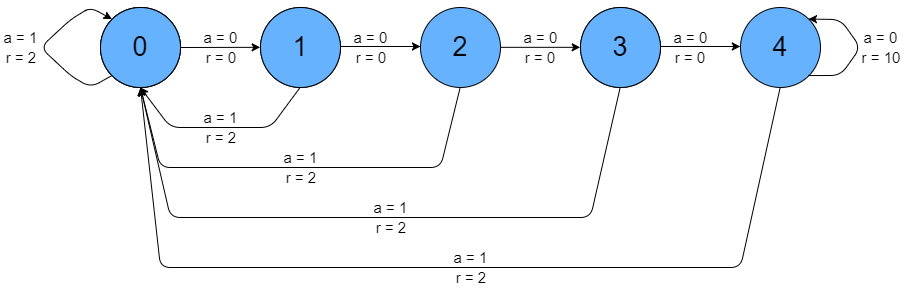

In [1]:
from IPython.display import Image
Image(filename = 'NChain-illustration.png', width=1000, height=100)
# Image taken from:
# https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/

In [2]:
# first we have to install the gym module, which contains the NChain environment
!pip install gym

In [3]:
# load the necessary pytho modules
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
import sys
import warnings
import time

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [4]:
# initialize the nchain environment
env = gym.make('NChain-v0')

In [5]:
# get 10 randomly sampled actions
[env.action_space.sample() for ii in range(10)]

[1, 0, 0, 1, 0, 1, 0, 0, 1, 0]

In [27]:
# define the class which consists the q-learning algorithm
class QAgent(object):
    
    def __init__(self, env, name, state_size, action_size, learning_parameters, exploration_parameters): 
        """
        initialize the q-learning agent
        Args:
          name (str): set the name of the Q-Agent
          state_size (int): ..
          action_size (int): ..
          learning_parameters (dict): 
          exploration_parameters (dict):
          
        """
        self.name = name
                
        # init the Q-table
        self.qtable = np.zeros((state_size, action_size))
        self.result = np.zeros((state_size, action_size))
        
        # learning parameters
        self.learning_rate = learning_parameters['learning_rate']
        self.gamma = learning_parameters['gamma']
        
        # exploration parameters
        self.epsilon = exploration_parameters['epsilon']      
        self.max_epsilon = exploration_parameters['max_epsilon']
        self.min_epsilon = exploration_parameters['min_epsilon']
        self.decay_rate = exploration_parameters['decay_rate']    
        
        self.env = env
        
    # define the q learning algorithm
    def q_learning(self, plot = False, max_steps = 10, total_episodes = 1000):
        """
        implementation of the q-learning algorithm, here the q-table values are calculated
        Args:
          plot (boolean): set true, to get trainings progress 
          max_steps (int): number of stepts an agent can take, before the environment is reset 
          total_episodes (int): total of training episodes (the number of trials a agent can do)          
        """

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)
        
        start = time.time()
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()
            
            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):   
                
                # get action, e-greedy
                action = self.get_action(state)
                               
                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)

                self.qtable[state, action] = self.update_qtable(state, new_state, action, reward, done)
                state = new_state
                self.episode_rewards[episode_i] += reward            
                self.result = np.dstack((self.result, self.qtable))

                # check stopping criterion
                if done == True:
                    break
            
            self.episode_rewards[episode_i] /= step # average the reward
            self.episode_last_state[episode_i] = state # average the reward
            
            # reduce epsilon, for exploration-exploitation tradeoff
            self.update_epsilon(episode_i)
            
            if episode_i % 100 == 0 and plot:
                print('episode: {}'.format(episode_i))
                print('\telapsed time [min]: {}'.format(round( (time.time() - start)/60, 1)))

            
    def update_qtable(self, state, new_state, action, reward, done):
        # Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        return self.qtable[state,action] + self.learning_rate * \
                          (reward + self.gamma * np.max(self.qtable[new_state, :]) * (1- done) - self.qtable[state, action])
    
    def update_epsilon(self, episode):
        # reduce epsilon, exponential decay
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate*episode)

    def get_action(self, state):
        # select action e-greedy
        if random.uniform(0,1) >= self.epsilon:
            # exploitation, max value for given state
            action = np.argmax(self.qtable[state, :])
        else:
            # exploration, random choice
            action = self.env.action_space.sample()
        return action

In [49]:
# avoid slipping in on the chain
env.env.slip = 0

action_size = env.action_space.n
state_size = env.observation_space.n

# Set the Training parameters
# set true, to get printed out the trainings progress
plot = False 
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 10 
# Set total of training episodes (the number of trials a agent can do)    
total_episodes = 1000

### Agent 1
Create an agent that explores and takes future rewards into account

In [54]:
### case1
name = 'case1, the agent explores and takes future rewards into account'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1,
    'min_epsilon': 0.0,
    'decay_rate': 0.008} # smaller decay rate, more exploration

q_agent_1 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_1.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

### Agent 2
Create an agent that cares only about immediate rewards (gamma is very small)

In [50]:
### case2
name = 'case2, the agent cares only about immediate rewards (small gamma)'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.01} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.5,
    'min_epsilon': 0.0,
    'decay_rate': 0.008} # smaller decay rate, more exploration


q_agent_2 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_2.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)


### Agent 3
Create an agent that doesn't explore the environment (small epsilon)

In [55]:
### case3
name = "case3, the agent doesn't explore the environment (small epsilon)"

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9} # gamma = 1, we care about all future rewards equally as the current one  
                  # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.2,
    'min_epsilon': 0.0,
    'decay_rate': 0.5} # smaller decay rate, more exploration


q_agent_3 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_3.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

In [58]:
# create a visualization method
def visualize_episodes(*cases):

    plt.figure(figsize=(10,15))
    colour = ['orange', 'm','b','k','g']
    
    # 1
    plt.subplot(3,1,1)
    plt.title('Reward over time per episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_rewards, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)
    
    # 2
    plt.subplot(3,1,2)
    plt.title('Exploration parameter epsilon per episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_epsilon, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('Epsilon')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)  
    
    # 3
    plt.subplot(3,1,3)
    plt.title('Last state the agent is standing on at the end of the episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_last_state, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('state number')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)  
    plt.tight_layout()
    plt.show()
    

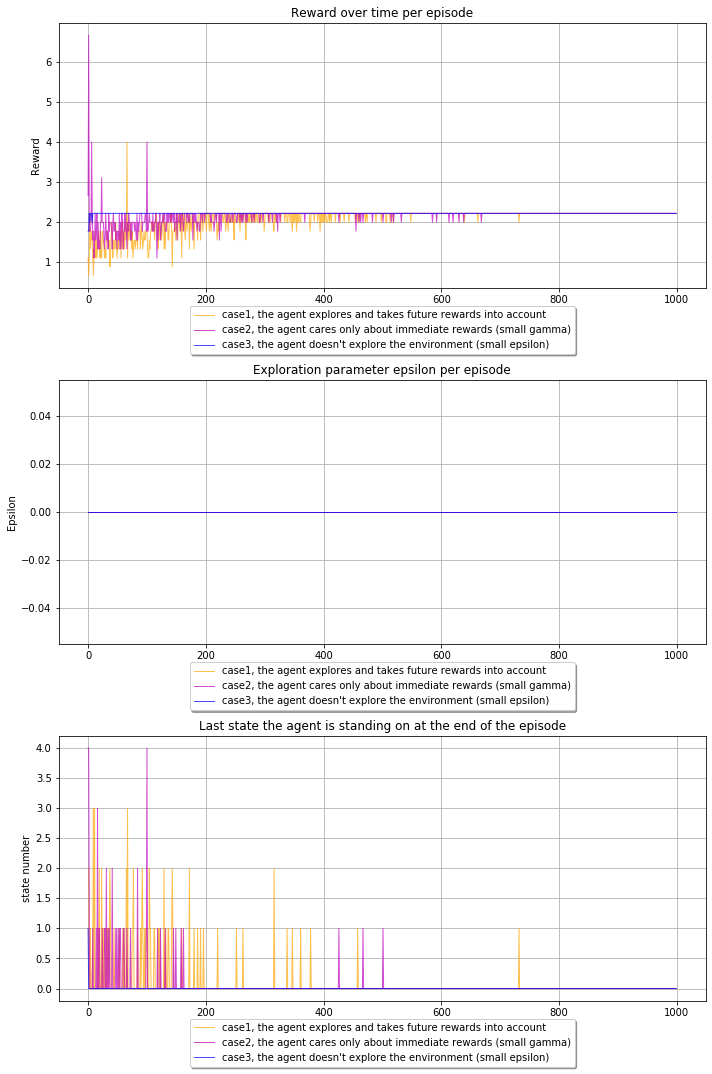

In [59]:
# visualize the different set of parameters
visualize_episodes(q_agent_1, q_agent_2, q_agent_3)

* y-axis: state 0 to state 4
* x-axis: action 0 and action 1
* action 0 = move forward, but get no reward (in the last state get large reward)
* action 1 = move backward to state 0, get small reward
### higher values mean higher future rewards for this specific action-state pair

In [60]:
print('case1:\n {},\n\ncase2:\n {},\n\ncase3:\n {}'.format(np.around(q_agent_1.qtable,1),
                                                     np.around(q_agent_2.qtable,1),
                                                     np.around(q_agent_3.qtable,1))) 


case1:
 [[18.  20. ]
 [18.  20. ]
 [18.  20. ]
 [18.  20. ]
 [34.3 20. ]],

case2:
 [[ 0.   2. ]
 [ 0.   2. ]
 [ 0.   2. ]
 [ 0.1  1.6]
 [10.1  1.9]],

case3:
 [[11.2 20. ]
 [ 0.  18.8]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 8.   3. ]]


The q-table of case1 should have similar values like the following table:

|    ----   | Action 0  | Action 1 | 
| ------------- | ------------- | ------------- |
| state 0 | 65.61  | 61.049  |
| state 1 | 72.9  | 61.049  |
| state 2 | 81.  | 61.049  |
| state 3 | 90.  | 61.049  |
| state 4 | 100.  | 61.049  |